# Sprawozdanie z zajęć nr 9
## Programowanie Równolegle i Rozproszone 2022/2023
### Uniwersytet w Białymstoku
### Karol Wójcik
### 80292

# <<< **MANDELBROT** >>> 

## Zadanie 2p
## 1. Dokonaj przekształcenia plików z wygenerowanymi fraktalami do postaci plików graficznych,
## które wyświetlisz.
## 2. Przedstaw na wykresach porównanie czasów wykonania programów na GPU (Colab) oraz
## CPU (Colab oraz komputer stacjonarny) w zależności od rozmiaru problemu (stała DIM). W
##optymalnym przypadku wykresy powinny zostać zrealizowane z matplotlib i dołączone do
##Colab.
## 3. Punkty 1,2 zrealizuj dla fraktala Mandelbrota.
## 4. Zrealizuj pracę w postaci sprawozdania w Google Colab – dokonaj także opisu programów i
## zrealizowanych czynności – ma to mieć postać tutoriala dla osoby, która nie na związku z
## przedmiotem

# Zapraszam na dysk w którym są zdjecia wygenerowanych fraktali 

https://drive.google.com/drive/folders/1DzqlUiPvbAacNRjjvMXClgZyVZ3zfoKk?usp=sharing

# Po wygenerowaniu fraktala nalezy go odpalić w np File Viewer 4 plus / Gimp /  otworzyć za pomoca pythona 

## 1. zmiana środowiska wykonawczego z CPU na GPU 
## Środowisko wykonawcze - > Zmień typ środowiska wykonawczego - > GPU - > ZAPISZ
## 2. Instalacja i sprawdzenie wersji 


In [1]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-0wr1hv_8
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-0wr1hv_8
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=8a04b6023ab6d8a69cb9635606f8b38be13e2ff590edabde2bc4187456e9cadc
  Stored in directory: /tmp/pip-ephem-wheel-cache-4mg8i6iu/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


## 3. program na CUDA bez uzycia GPU, wykorzystujacy CPU czyli Procesor 

# <<< opis programu >>> 

### 1. %%cu - wykorzystane by moc kompilowac kod cuda w Google Collab 
### 2. cuComplex stworzona klasa / struktura w C r to rzeczywiste , i imagine (urojone) , zaimplementowane mnozenie i dodawanie wyimaginowanych liczb przeciazajac operatory ( *  ) i ( + ) 

### 3. mandelbrot2 funkcja ktora zwraca 1 jesli punkt znajduje sie w zbiorze mandelbrota i 0 jesli nie 

### 4. kernel funkcja ktora liczy iteracyjnie wartosc pikseli 
### wykorzystuje offset któy umozliwa nam przenoszenie wartosci RGB 
### z = z * z + c; wzor na mandelbrota 
### 

### 5.  save to file zapisuje plik do plik .ppm

### 6. main liczy czas , wywoluje funkcje 

In [68]:
%%cu
#include<stdio.h>
#include <time.h>
#define DIM 2000




struct cuComplex {
    float   r;
    float   i;
    cuComplex( float a, float b ) : r(a), i(b)  {}
    float magnitude2( void ) { return r * r + i * i; }
    cuComplex operator*(const cuComplex& a) {
        return cuComplex(r*a.r - i*a.i, i*a.r + r*a.i);
    }
    cuComplex operator+(const cuComplex& a) {
        return cuComplex(r+a.r, i+a.i);
    }
};



int mandelbrot2(double x, double y) {
    const float scale = 1.5;
    float jx = scale * (float)(DIM/2 - x)/(DIM/2);
    float jy = scale * (float)(DIM/2 - y)/(DIM/2);
    cuComplex c(jx, jy);
    cuComplex z(0, 0);
    for (int i = 0; i < 200; i++) {
    z = z * z + c;
      if (z.magnitude2() > 1000) {
        return 0;
    }
  }
  return 1;
}


void kernel( unsigned char *ptr ){
    for (int y=0; y<DIM; y++) {
        for (int x=0; x<DIM; x++) {
            int offset = x + y * DIM;
            int mandelbrotValue = mandelbrot2( x, y );
            ptr[offset*4 + 0] = 19;
            ptr[offset*4 + 1] = 255 * mandelbrotValue ;
            ptr[offset*4 + 2] = 72;
            ptr[offset*4 + 3] = 200;
        }
    }
 }

struct DataBlock{
    unsigned char *dev_bitmap; 
};

void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("MandelCPU.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}


int main( void ) {
       clock_t start_time = clock();

    DataBlock data ; 
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM * DIM * 4 ;
    kernel(bitmap);
    save_to_file(bitmap);
    // Record the end time
    clock_t end_time = clock();

    // Calculate the elapsed time in milliseconds
    double elapsed_time = (double)(end_time - start_time) / CLOCKS_PER_SEC * 1000;

    printf("milliseconds %f \n", elapsed_time);
    long milliseconds = elapsed_time ; 
    // Convert the milliseconds to seconds
    long seconds = milliseconds / 1000.0;
    // Print the result
    printf("%d seconds\n",  seconds);


    return 0;

}

milliseconds 6025.248000 
6 seconds



### 4. program na CUDA przy uzycia GPU, wykorzystujacy karte graficzna

# <<< opis programu >>> 

### 1. %%cu - wykorzystane by moc kompilowac kod cuda w Google Collab 
### 2. cuComplex stworzona klasa / struktura w C r to rzeczywiste , i imagine (urojone) , zaimplementowane mnozenie i dodawanie wyimaginowanych liczb przeciazajac operatory ( *  ) i ( + ) 

### 3. mandelbrot2 funkcja ktora zwraca 1 jesli punkt znajduje sie w zbiorze mandelbrota i 0 jesli nie 

### 4. kernel funkcja ktora liczy na karcie graficznej zamiast iteracyjnie  
### wykorzystuje offset któy umozliwa nam przenoszenie wartosci RGB 
### z = z * z + c; wzor na mandelbrota 
### Pola x i y zmiennej blockIdx reprezentują indeksy bloku wymiarach x i y,odpowiednio.
###Na przykład, w następującym fragmencie kodu:
###int x = blockIdx.x;
###int y = blockIdx.y;
###zmienna x będzie zawierać indeks bloku w wymiarze x, a zmienna y będzie zawierać indeks bloku w wymiarze y. Te indeksy mogą być użyte do jednoznacznego identyfikowania bloku wątków w siatce i obliczania położenia bloku w siatce. 

### 5.  save to file zapisuje plik do plik .ppm

### 6. main liczy czas , wywoluje funkcje 

In [58]:
%%cu
#include<stdio.h>
#define DIM 2000
#include <cuda_runtime.h>

struct cuComplex {
    float   r;
    float   i;
    // cuComplex( float a, float b ) : r(a), i(b)  {}
    __device__ cuComplex( float a, float b ) : r(a), i(b) {} // Fix error for calling host function from device
    __device__ float magnitude2( void ) {
        return r * r + i * i;
    }
    __device__ cuComplex operator*(const cuComplex& a) {
        return cuComplex(r*a.r - i*a.i, i*a.r + r*a.i);
    }
    __device__ cuComplex operator+(const cuComplex& a) {
        return cuComplex(r+a.r, i+a.i);
    }
};


__device__ int mandelbrot2(double x, double y) {
    const float scale = 1.5;
    float jx = scale * (float)(DIM/2 - x)/(DIM/2);
    float jy = scale * (float)(DIM/2 - y)/(DIM/2);
    cuComplex c(jx, jy);
    cuComplex z(0, 0);
    for (int i = 0; i < 200; i++) {
    z = z * z + c;
      if (z.magnitude2() > 1000) {
        return 0;
    }
  }
  return 1;
}


__global__ void kernel( unsigned char *ptr ) {
    // map from blockIdx to pixel position
    int x = blockIdx.x;
    int y = blockIdx.y;
    int offset = x + y * gridDim.x;

    // now calculate the value at that position
    int man =  mandelbrot2( x, y );
    ptr[offset*4 + 0] = 150;
    ptr[offset*4 + 1] = 220;
    ptr[offset*4 + 2] = 177 * man;
    ptr[offset*4 + 3] = 12;
}

// globals needed by the update routine
struct DataBlock {
    unsigned char   *dev_bitmap;
};



void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("MandelGPU.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}

int main( void ) {
    // Create the start and end events
    cudaEvent_t start, end;
    cudaEventCreate(&start);
    cudaEventCreate(&end);

    // Record the start time
    cudaEventRecord(start, 0);

    
    DataBlock data ; 
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM * DIM * 4 ;
    unsigned char *dev_bitmap;
    cudaMalloc((void**)&dev_bitmap,image_size);
    data.dev_bitmap = dev_bitmap ;
    dim3 grid(DIM,DIM);
    kernel<<<grid,1>>>(dev_bitmap);
    cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost) ;   
    cudaFree(dev_bitmap);
    save_to_file(bitmap);
       // Record the end time
    cudaEventRecord(end, 0);

    // Synchronize the stream to wait for the kernel to finish
    cudaEventSynchronize(end);

    // Calculate the elapsed time
    float elapsed_time;
    cudaEventElapsedTime(&elapsed_time, start, end);

    // Print the elapsed time in milliseconds
    printf("Elapsed time: %f milliseconds\n", elapsed_time);

    // Destroy the events
    cudaEventDestroy(start);
    cudaEventDestroy(end);


}

Elapsed time: 634.012207 milliseconds



#GPU time 59.203777    DIM 600
#GPU time 105.271072   DIM 800
#GPU time 163.239304   DIM 1000
#GPU time 223.393799   DIM 1200
#GPU time 309.888153   DIM 1400
#GPU time 417.935242   DIM 1600
#GPU time 545.383118   DIM 1800
#GPU time 634.012207   DIM 2000

#CPU  time 525.729000 DIm 600
#CPU time  962.112000  DIM 800
#CPU  time 1438.720000  DIM 1000  
#CPU time 2086.150000  DIM 1200
#CPU time 2963.573000  DIM 1400
#CPU time 3731.129000  DIM 1600
#CPU time 4805.774000  DIM 1800
#CPU time 5761.879000 DIM 2000


# 5 WYKRES 

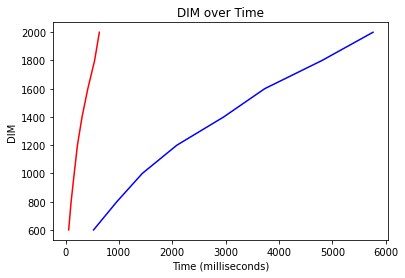

In [64]:
import matplotlib.pyplot as plt

# dodanie do tablic wartosci time i dim  
time_ms_cpu = [ 525.729000 , 962.112000  , 1438.720000   , 2086.150000  , 2963.573000 , 3731.129000  , 4805.774000  , 5761.879000 ]
dim_cpu = [600 , 800 , 1000 , 1200 , 1400 , 1600 , 1800 , 2000  ]

time_ms_GPU = [ 59.203777  ,105.271072   ,163.239304 ,223.393799  ,309.888153  ,417.935242  ,545.383118   ,634.012207 ]
dim_GPU = [600 , 800 , 1000 , 1200 , 1400 , 1600 , 1800 , 2000]

# stowrzenie wykresu funkcja plot
plt.plot(time_ms_cpu, dim_cpu, color='blue', label='CPU')
plt.plot(time_ms_GPU ,dim_GPU  , color='red' , label='GPU' )

# tytyl , os x i y 
plt.xlabel('Time (milliseconds)')
plt.ylabel('DIM')
plt.title('DIM over Time')

# pokaz wykres 
plt.show()

## 6 Moj nie dzialający innowacyjny kod 

In [69]:
%%cu



#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define DIM 1500

//2000
struct Color {
    unsigned char r, g, b;
};

struct cuComplex {
    float real, imag;
    cuComplex(float r, float i) : real(r), imag(i) {}
    float magnitude2() { return real * real + imag * imag; }
    cuComplex operator*(const cuComplex& a) {
        return cuComplex(real * a.real - imag * a.imag, real * a.imag + imag * a.real);
    }
    cuComplex operator+(const cuComplex& a) {
        return cuComplex(real + a.real, imag + a.imag);
    }
};

int mandelbrot(int x, int y, int maxIterations) {
    const float scale = 1.5;
    // bylo 1.5
    float jx = scale * (float)(DIM/2 - x)/(DIM/2);
    float jy = scale * (float)(DIM/2 - y)/(DIM/2);

    cuComplex a(jx, jy);

    int i = 0;
    for (i = 0; i < maxIterations; i++) {
        a = a * a + a;
        // bylo 1000
        if (a.magnitude2() > 1000) {
            return i;
        }
    }

    return i;
}

Color getColorFromPalette(int value, int maxIterations) {
    int red = (value * 255) / maxIterations;
    int green = (value * 255) / maxIterations;
    int blue = 255 - (value * 255) / maxIterations;

    return { (unsigned char)red, (unsigned char)green, (unsigned char)blue };
}

void kernel(unsigned char *ptr, int maxIterations) {
    for (int y = 0; y < DIM; y++) {
        for (int x = 0; x < DIM; x++) {
            int offset = x + y * DIM;

            int mandelbrotValue = mandelbrot(x, y, maxIterations);
            if (mandelbrotValue == maxIterations) {
                ptr[offset * 4 + 0] = 0;
                ptr[offset * 4 + 1] = 0;
                ptr[offset * 4 + 2] = 0;
                ptr[offset * 4 + 3] = 0;
            } else {
                ptr[offset * 4 + 0] = getColorFromPalette(mandelbrotValue, maxIterations).r;
                ptr[offset * 4 + 1] = getColorFromPalette(mandelbrotValue, maxIterations).g;
                ptr[offset * 4 + 2] = getColorFromPalette(mandelbrotValue, maxIterations).b;
                ptr[offset * 4 + 3] = 255;
            }
        }
    }
}

void wypisz_RGB_fraktal(unsigned char *data) {
  for (int i=0; i<DIM*DIM*4; i+=4)
    printf("%3d %3d %3d\n", data[i], data[i+1], data[i+2]);
}

void save_to_file(unsigned char *data) {
  FILE *f = fopen("out.ppm", "w");
  fprintf(f, "P6\n%d %d\n255\n", DIM, DIM);
  fwrite(data, 1, DIM*DIM*4, f);
  fclose(f);
}

void save_to_pam(unsigned char *data) {
  FILE *f = fopen("out.pam", "w");
  fprintf(f, "P7\nWIDTH %d\nHEIGHT %d\nDEPTH 4\nMAXVAL 255\nTUPLTYPE RGB_ALPHA\nENDHDR\n", DIM, DIM);
  fwrite(data, 1, DIM*DIM*4, f);
  fclose(f);
}

int main(void) {
    unsigned char *bitmap = (unsigned char*)malloc(DIM * DIM * 4 * sizeof(unsigned char));

    // Call the kernel
    kernel(bitmap, 500);
   // kernel(bitmap , 20);
   
 //wypisz_RGB_fraktal(bitmap);
    save_to_file(bitmap);
    save_to_pam(bitmap);

    return 0;
}

### przyklad otwarcia w pythonie

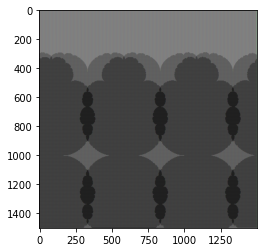

In [70]:
import matplotlib.pyplot as plt
from PIL import Image
im = Image.open("out.ppm")
plt.imshow(im)
plt.show()